# Instalar nltk

In [ ]:
# Correr aquí
!pip install nltk

In [4]:
# from __future__ import print_function
import spaghetti as sgt
import re
import nltk
import numpy as np
import json

### Descargar los corpus
```python 
nltk.download()
```

### archivos contenidos en carpeta
- spaghetti.py
- facturaskeys.json
- entendimiento.ipynb

### definicion de palabras asociadas a los campos y de patrones de expresiones regulares

In [5]:
dictfacturas = json.load(open("facturaskeys.json"))
print(dictfacturas)

patterns = dict(Cuenta=r"\b[A-Za-z]{3}\d{3}\b",
                Prefijo=r"\b[1-9a-zA-Z]\w{0,3}\b",  # wvect
                NoDocumento=r"\b[0-9a-zA-Z\-]{1,40}\b",  # w2vect
                NitAdquirienteMex=r"\b[A-Za-z]{4}\d{6}[A-Za-z0-9]{3}\b")

{'Prefijo': ['prefijo', 'serie'], 'NoDocumento': ['documento', 'documentos', 'nota', 'notas', 'crédito', 'créditos', 'credito', 'creditos', 'facturas', 'factura', 'numero', 'número'], 'Folio': ['folio', 'folios'], 'Inicio': ['inicial', 'inicio', 'comienza', 'comienzan', 'comienzo', 'empieza', 'empiezan', 'principio', 'principian', 'arranque', 'inicia', 'inicien', 'inician', 'inicializacion', 'inicialización'], 'Fin': ['final', 'fin', 'finaliza', 'termina', 'concluye', 'terminal', 'finalicen', 'finalizan', 'finalizado', 'finalice', 'finalizacion', 'finalización', 'cierre'], 'Singlel': ['b', 'c', 'd', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'ñ', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'z'], 'Es': ['es', 'ser', 'son', 'igual', 'definido', 'tiene'], 'Valor': ['valor'], 'Reciente': ['reciente'], 'De': ['de'], 'Estado': ['estado', 'estatus'], 'NitAdquirienteMex': ['nit', 'adquiriente', 'rfc'], 'Sust': ['número', 'numero', 'clave', 'matrícula', 'matricula', 'numeración'], 'Cuenta': ['cue

### NOTA: 

    Añadir al archivo facturaskeys.json los sinónimos que crean necesarios para cada campo, 
    respetando la estructura json

### funciones

Nota:

    - Le hice cambios a la función do_tagged() resaltados con "##" revisar.
    - Ya casi está terminada lo de no. de documento.
    - Revisar los temas que añadí al notebook, son consejos y la observación sobre la definición correcta de Q.

In [6]:
def regexextractor(expression, field):
    pattern = patterns[field]
    result = re.search(pattern=pattern, string=expression)
    if result:
        return result.group()
    else:
        return None

def do_tagging(exp, field):
    tokens = nltk.word_tokenize(exp)
    tagged = sgt.pos_tag(tokens)
    tagged = np.array([list(tup) for tup in tagged]).astype(str) 
    ## Añadir a script
    ########################
    key = "Singlel"
    related = dictfacturas[key]
    for i, token in enumerate(tokens):
        if token in dictfacturas[field]:
            tagged[i, 1] = str(field)
        elif token in related:
            tagged[i, 1] = key
    #######################
    mask = tagged[:, 1] == 'None'
    unknowns, = np.where(mask)
    for unknown in unknowns:
        if regexextractor(tokens[unknown], field) is not None:
            tagged[unknown, 1] = "dato"
        else:
            tagged[unknown, 1] = "unknown"
    return [tuple(wordtagged) for wordtagged in tagged]

def do_chunking(grammar, tagged, field, code):
    # añadir las condiciones que sean necesarias para contemplar
    # los posibles valores de campo
    posibles = ['Fz', 'Y', 'Z', 'cc', 'dato', 'nccn000', "ncms000"
                'ncfs000', 'sps00', 'Singlel']
    # posibles son los tipos de palabras que pueden representar al dato
    
    cp = nltk.RegexpParser(grammar)
    chunked = cp.parse(tagged)
    continuous_chunk = []
    entity = []
    unknowns = []
    subt = []
    for i, subtree in enumerate(chunked):
        if isinstance(subtree, nltk.Tree) and subtree.label() == "NP":
            # añadir las condiciones que sean necesarias para contemplar los posibles valores
            entity += [token for token, pos in subtree.leaves()
                       if pos in posibles]
            unknowns += [token for token, pos in subtree.leaves()
                         if pos == "unknown"]
            subt.append(subtree)
    if entity == []:
        code = 0
        if len(unknowns) > 1:
            entity = unknowns[-1].upper()
        elif unknowns != []:
            entity = unknowns[0].upper()
        else:
            entity = None
    elif len(entity) > 1:
        code = 0
        entity = entity[-1].upper()
    else:
        entity = entity[0].upper()
        if regexextractor(entity, field) is not None:
            code = 1
        else:
            code = 0
    return entity, code, subt, tagged

In [13]:
do_tagging('enero febrero marzo abril mayo junio julio agosto septiembre octubre noviembre diciembre 1999 \
           2000 2001 2200 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 \
           30 31 32 primero segundo tercero cuarto quinto sexto séptimo octavo noveno', 'NoDocumento')

[('enero', 'W'),
 ('febrero', 'W'),
 ('marzo', 'W'),
 ('abril', 'W'),
 ('mayo', 'W'),
 ('junio', 'W'),
 ('julio', 'W'),
 ('agosto', 'W'),
 ('septiembre', 'W'),
 ('octubre', 'W'),
 ('noviembre', 'W'),
 ('diciembre', 'W'),
 ('1999', 'W'),
 ('2000', 'W'),
 ('2001', 'W'),
 ('2200', 'dato'),
 ('1', 'Z'),
 ('2', 'Z'),
 ('3', 'Z'),
 ('4', 'Z'),
 ('5', 'Z'),
 ('6', 'Z'),
 ('7', 'Z'),
 ('8', 'Z'),
 ('9', 'Z'),
 ('10', 'Z'),
 ('11', 'Z'),
 ('12', 'Z'),
 ('13', 'Z'),
 ('14', 'Z'),
 ('15', 'Z'),
 ('16', 'Z'),
 ('17', 'Z'),
 ('18', 'Z'),
 ('19', 'Z'),
 ('20', 'Z'),
 ('21', 'Z'),
 ('22', 'Z'),
 ('23', 'Z'),
 ('24', 'Z'),
 ('25', 'Z'),
 ('26', 'Z'),
 ('27', 'Z'),
 ('28', 'Z'),
 ('29', 'Z'),
 ('30', 'Z'),
 ('31', 'Z'),
 ('32', 'Z'),
 ('primero', 'ao0ms0'),
 ('segundo', 'ao0ms0'),
 ('tercero', 'ao0ms0'),
 ('cuarto', 'ao0ms0'),
 ('quinto', 'ao0ms0'),
 ('sexto', 'ao0ms0'),
 ('séptimo', 'ao0ms0'),
 ('octavo', 'ao0ms0'),
 ('noveno', 'dato')]

### NOTA: 
      
      la palabra prefijo no está en el diccionario, por lo tanto como es detectada como desconocida 
      pero cumple con la expresión regular del campo, la asigna como posible dato

# Ejemplo de grammar

```python
grammar = r"""Q: {<dato|Z|Fz|unknown|ncfs000>}
              T: {<dato|Fz|unknown|sps00>}
              NP: {<Prefijo> <(vs\w+)|(nc\w+)|(wmi\w+)|(spc\w+)>* <Q>}
              NP: {<Prefijo> <T>}
              NP: {<Prefijo> <(vmi\w+)|(aq\w+)|unknown>? <sp\w+>? <Q>}
              NP: {<Prefijo> <dd0fs0> <vmp00sm> <sps00> <Q>}
              NP: {<Q> <(vs\w+)> <(da\w+)> <Prefijo>}
              NP: {<Q> <(p030\w+)>? <vmip3s0>? <cs> <Prefijo>}
            """
```
### Nota:
    
    falta definir nodos terminales

# Para diseñar las reglas y probar

NOTA:
    
    Correr cada que se cambie el grammar

In [113]:
grammar = r"""Q: {<dato|Z|Fz|unknown|ncfs000>}
              T: {<dato|Fz|unknown|sps00>}
              NP: {<Prefijo> <(vs\w+)|(nc\w+)|(wmi\w+)|(spc\w+)>* <Q>}
              NP: {<Prefijo> <T>}
              NP: {<Prefijo> <(vmi\w+)|(aq\w+)|unknown>? <sp\w+>? <Q>}
              NP: {<Prefijo> <dd0fs0> <vmp00sm> <sps00> <Q>}
              NP: {<Q> <(vs\w+)> <(da\w+)> <Prefijo>}
              NP: {<Q> <(p030\w+)>? <vmip3s0>? <cs> <Prefijo>}
            """

def prueba(exp, field): 
    tagged = do_tagging(exp.lower(), field)
    return do_chunking(grammar, tagged, field, 1)

NOTA:
    
    salida: (VALOR, CODIGO DE VALIDEZ, FRASE ETIQUETADA QUE CUMPLE CON GRAMMAR, FRASE ETIQUETADA)

In [7]:
exp = 'escuela es el prefijo'
field = "Prefijo"
prueba(exp, field)

('ESCUELA',
 0,
 [Tree('NP', [Tree('Q', [('escuela', 'ncfs000')]), ('es', 'vsip3s0'), ('el', 'da0ms0'), ('prefijo', 'Prefijo')])],
 [('escuela', 'ncfs000'),
  ('es', 'vsip3s0'),
  ('el', 'da0ms0'),
  ('prefijo', 'Prefijo')])

# De Gerardo

Valores para agregar en facturaskeys.json

```json
{"Estatus": ["estado","estatus"],
 "Acuse": ["acuse"]}
```
Actualizar grammar

```python

grammar = r"""NP: {<Estatus> <(vs\w+)|(nc\w+)|(wmi\w+)|(spc\w+)>* <dato|Z|unknown>}
              NP: {<Estatus> <(vmi\w+)|(aq\w+)|unknown>? <sp\w+>? <dato|Z|unknown>}
              NP: {<Estatus> <dd0fs0> <vmp00sm> <sps00> <aq0cs0> <ncms000> <pr0ms000> <aq0msp> <vmip3s0> <dato|Z|unknown>}
              NP: {<dato|Z|unknown> <(vs\w+)> <(da\w+)> <Estatus>}
              NP: {<dato|Z|unknown> <(p030\w+)>? <vmip3s0>? <cs> <Estatus>}
           """

grammar = r"""NP: {<Acuse> <(vs\w+)|(nc\w+)|(wmi\w+)|(spc\w+)>* <dato|Z|unknown>}
              NP: {<Acuse> <(vmi\w+)|(aq\w+)|unknown>? <sp\w+>? <dato|Z|unknown>}
              NP: {<Acuse> <dd0fs0> <vmp00sm> <sps00> <aq0cs0> <ncms000> <pr0ms000> <aq0msp> <vmip3s0> <dato|Z|unknown>}
              NP: {<dato|Z|unknown> <(vs\w+)> <(da\w+)> <Acuse>}
              NP: {<dato|Z|unknown> <(p030\w+)>? <vmip3s0>? <cs> <Acuse>}
           """
```

# Solución No. de Documento

In [261]:
letras = [c for c in "abcdefghijklmnñopqrstuvwxyz1234567890"]
tagged = do_tagging(" ".join(letras), "NoDocumento")
Q = '|'.join(np.unique([tag[1] for tag in tagged]))
Q

'Singlel|Z|cc|sps00'

In [263]:
frases = ["documento con numero x",
          "documento con número y",
          "documento de numero x",
          "documento de número 22",
          "documento con numero igual a x",
          "documento con número igual a e",
          "documento con aaagg como numero",
          "documento con x como número",
          "numero de documento es 100",
          "número de documento es 100",
          "con número de documento x",
          "con numero de documento a",
          "el numero de documento es y",
          "12 es el numero de documento"]

for frase in frases:
    tagged = do_tagging(frase, "NoDocumento")
    print([tag[1] for tag in tagged])

['NoDocumen', 'sps00', 'NoDocumen', 'Singlel']
['NoDocumen', 'sps00', 'ncms000', 'cc']
['NoDocumen', 'sps00', 'NoDocumen', 'Singlel']
['NoDocumen', 'sps00', 'ncms000', 'Z']
['NoDocumen', 'sps00', 'NoDocumen', 'aq0cs0', 'sps00', 'Singlel']
['NoDocumen', 'sps00', 'ncms000', 'aq0cs0', 'sps00', 'cc']
['NoDocumen', 'sps00', 'dato', 'cs', 'NoDocumen']
['NoDocumen', 'sps00', 'Singlel', 'cs', 'ncms000']
['NoDocumen', 'sps00', 'NoDocumen', 'vsip3s0', 'Z']
['ncms000', 'sps00', 'NoDocumen', 'vsip3s0', 'Z']
['sps00', 'ncms000', 'sps00', 'NoDocumen', 'Singlel']
['sps00', 'NoDocumen', 'sps00', 'NoDocumen', 'sps00']
['da0ms0', 'NoDocumen', 'sps00', 'NoDocumen', 'vsip3s0', 'cc']
['Z', 'vsip3s0', 'da0ms0', 'NoDocumen', 'sps00', 'NoDocumen']


### Reglas gramaticales para no. de documento y solución

In [265]:
grammar = r""" Q: {<cc|dato|Z|Singlel|unknown>}
               NP: {<(NoDocum\w+)> <sps00> <(NoDocum\w+)|ncms000> <Q|ncms000>}
               NP: {<(NoDocum\w+)> <sps00> <(NoDocum\w+)|ncms000> <aq0cs0>? <sps00|vsip3s0>? <Q|ncms000>}
               NP: {<sps00> <(NoDocum\w+)|ncms000> <aq0cs0>? <sps00|vsip3s0>? <Q|ncms000>}
           """

posibles = ['Fz', 'Y', 'Z', 'cc', 'dato', 'nccn000', "ncms000"
            'ncfs000', 'sps00', 'Singlel']

exps = ["documento con numero x",
        "documento con número y",
        "documento de numero x",
        "documento de número 22",
        "documento con numero igual a x",
        "documento con número igual a e",
        "documento con aaagg como numero",
        "documento con x como número",
        "numero de documento es 100",
        "número de documento es 100",
        "con número de documento x",
        "con numero de documento a",
        "el numero de documento es y",
        "12 es el numero de documento"]

def prueba(exp, field, todo=True): 
    tagged = do_tagging(exp.lower(), field)
    result = do_chunking(grammar, tagged, field, 1)
    if todo:
        print(exp, "\n", result)
    else:
        print(exp, "\n", result[:2])
    return result

for exp in exps:
    prueba(exp, "NoDocumento", False)

documento con numero x 
 ('X', 0)
documento con número y 
 ('Y', 0)
documento de numero x 
 ('X', 0)
documento de número 22 
 ('22', 0)
documento con numero igual a x 
 ('X', 0)
documento con número igual a e 
 ('E', 0)
documento con aaagg como numero 
 (None, 0)
documento con x como número 
 (None, 0)
numero de documento es 100 
 ('100', 0)
número de documento es 100 
 ('100', 0)
con número de documento x 
 ('X', 0)
con numero de documento a 
 (None, 0)
el numero de documento es y 
 ('Y', 0)
12 es el numero de documento 
 (None, 0)


## Ejemplo de como si usan un Q con un elemento, despues no se puede utilizar el elemento por separado

1.- Notar la diferencia en el Q

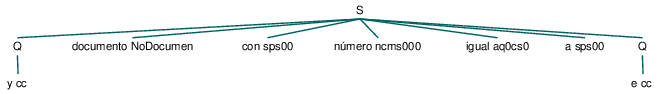

In [255]:
tagged = do_tagging("y documento con número igual a e", "NoDocumento")
grammar = r"""Q: {<cc|dato|Z|Singlel|unknown|>}
              NP: {<cc> <(NoDocum\w+)> <sps00> <(NoDocum\w+)|ncms000> <aq0cs0> <sps00> <Q>}
           """
cp = nltk.RegexpParser(grammar)
chunked = cp.parse(tagged)
chunked

2.- Notar que si se le quita el 'cc' dentro del Q si encuentra la frase

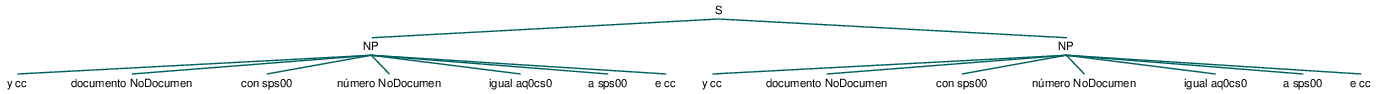

In [15]:
tagged = do_tagging("y documento con número igual a e y documento con número igual a e", "NoDocumento")
grammar = r"""Q: {<dato|Z|Singlel|unknown>}
              NP: {<cc> <(NoDocum\w+)> <sps00> <(NoDocum\w+)|ncms000> <aq0cs0> <sps00> <Q|cc>}
           """
cp = nltk.RegexpParser(grammar)
chunked = cp.parse(tagged)
chunked

### Para que puedan avanzar más rápido en la creación de estructuras

```python
['NoDocumen', 'sps00', 'NoDocumen', 'dato']
['NoDocumen', 'sps00', 'ncms000', 'cc']
['NoDocumen', 'sps00', 'NoDocumen', 'dato']
['NoDocumen', 'sps00', 'ncms000', 'Z']
['NoDocumen', 'sps00', 'NoDocumen', 'aq0cs0', 'sps00', 'dato']
['NoDocumen', 'sps00', 'ncms000', 'aq0cs0', 'sps00', 'cc']
['NoDocumen', 'sps00', 'dato', 'cs', 'NoDocumen']
['NoDocumen', 'sps00', 'dato', 'cs', 'ncms000']
['NoDocumen', 'sps00', 'NoDocumen', 'vsip3s0', 'Z']
['ncms000', 'sps00', 'NoDocumen', 'vsip3s0', 'Z']
['sps00', 'ncms000', 'sps00', 'NoDocumen', 'dato']
['sps00', 'NoDocumen', 'sps00', 'NoDocumen', 'sps00']
```

```python
Q: {<dato|Z|ncms000>}

NP: {<NoDocumen> <sps00> <NoDocumen|ncms000> <Q>}

NP: {<sps00> <NoDocumen|ncms000> <sps00> <NoDocumen> <Q>}
```

## Para sacar los tipos de palabras contenidos en el corpus, por tipo

In [ ]:
from nltk.corpus import cess_esp

palabras = cess_esp.tagged_words()
palabras = np.array(palabras)

cosas = np.unique([tup[1] for tup in palabras])
dictt = {}
for key in cosas:
    dictt.update(dict(zip([key], [np.unique([palabra[0] for palabra in palabras if palabra[1] == key])])))
print(dictt)

In [85]:
print(dictt["cc"])

['E' 'Es_decir' 'Mas' 'Mientras_que' 'Ni' 'No_bien' 'No_obstante' 'O'
 'O_sea' 'Pero' 'Sin_embargo' 'Y' 'a_la_vez_que' 'a_saber' 'además_de'
 'al_igual_que' 'al_tiempo_que' 'así_como' 'así_como_también' 'como' 'e'
 'en_tanto_que' 'es' 'es_decir' 'esto_es' 'igual_que' 'lo_mismo_que'
 'mientras' 'mientras_que' 'más' 'más_que' 'ni' 'no_obstante'
 'no_solamente' 'no_sólo' 'o' 'o_bien' 'o_sea' 'pero' 'que' 'sin_embargo'
 'sino' 'sino_que' 'sino_que_además' 'sino_también' 'u' 'y' 'ó']


## Ejemplo de como funciona la búsqueda de la estructura y la palabra dentro de ella

In [250]:
tagged = sgt.pos_tag("Mi madre me ama y me canta".split())
print("Palabras Etiquetadas: ", tagged, "\n")
grammar = r"NP: {<pp1cs000> <ncfs000>}"
cp = nltk.RegexpParser(grammar)
chunked = cp.parse(tagged)
for subtree in chunked:
    if isinstance(subtree, nltk.Tree) and subtree.label() == "NP":
        print("Frase encontrada: ", subtree.label(), subtree.leaves())

Palabras Etiquetadas:  [('Mi', 'dp1css'), ('madre', 'ncfs000'), ('me', 'pp1cs000'), ('ama', 'ncfs000'), ('y', 'cc'), ('me', 'pp1cs000'), ('canta', 'vmip3s0')] 

Frase encontrada:  NP [('me', 'pp1cs000'), ('ama', 'ncfs000')]


In [20]:
if 0:
    print("Entré.")